In [31]:
using Plots; pyplot()
using Distributions
using AugmentedGaussianProcesses
using KernelFunctions

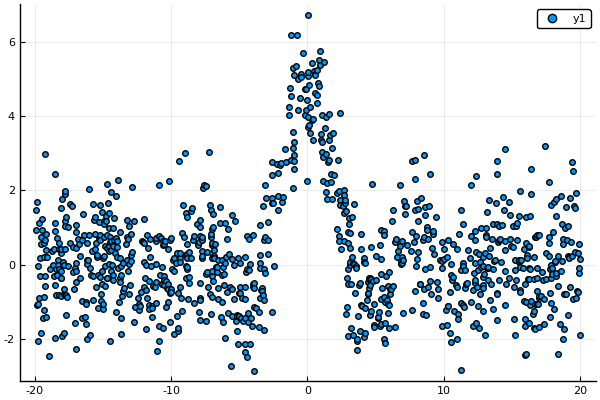

In [32]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
Y = (latent(X)+randn(N))[:];
scatter(X,Y)

In [33]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = SqExponentialKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m = SVGP(X, vec(Y), kernel,LaplaceLikelihood(),AnalyticVI(),num_inducing)
    @time train!(m,100)
    models[index]=m;
end

  0.089012 seconds (1.02 M allocations: 158.359 MiB, 33.94% gc time)


┌ Info: Training with 4 points
└ @ Main In[33]:6
┌ Info: Training with 8 points
└ @ Main In[33]:6


  0.121823 seconds (1.02 M allocations: 228.332 MiB, 32.21% gc time)


┌ Info: Training with 16 points
└ @ Main In[33]:6


  0.210213 seconds (1.03 M allocations: 370.224 MiB, 26.04% gc time)


┌ Info: Training with 32 points
└ @ Main In[33]:6


  0.347083 seconds (1.03 M allocations: 662.310 MiB, 24.10% gc time)


┌ Info: Training with 64 points
└ @ Main In[33]:6


  0.775999 seconds (1.04 M allocations: 1.250 GiB, 17.82% gc time)


In [34]:
@info "Training with full model"
mfull = VGP(X, vec(Y), kernel,LaplaceLikelihood(),AnalyticVI())
@time train!(mfull,5);
models[end]=mfull;

┌ Info: Training with full model
└ @ Main In[34]:1


  1.108469 seconds (4.75 k allocations: 567.738 MiB, 16.83% gc time)


In [35]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
    y,sig_y = proba_y(model,Xplot)
    return (y,sig_y,Xplot)
end;

In [36]:
function plotdata(X,Y)
    Plots.plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [39]:
function plotcontour(model,X,Y)
    nGrid = 100
    (y,sig_y,x) = compute_Grid(model,nGrid);
    p = plotdata(X,Y)
    Plots.plot!(p,x,y,ribbon=sqrt.(sig_y),title=((model isa SVGP) ? "M = $(model.nFeatures)" : "full"),color="red",lab="",linewidth=3.0)
    if model isa SVGP
        Plots.plot!(p,model.f[1].Z[:,1],zero(model.f[1].Z[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return p
    end;

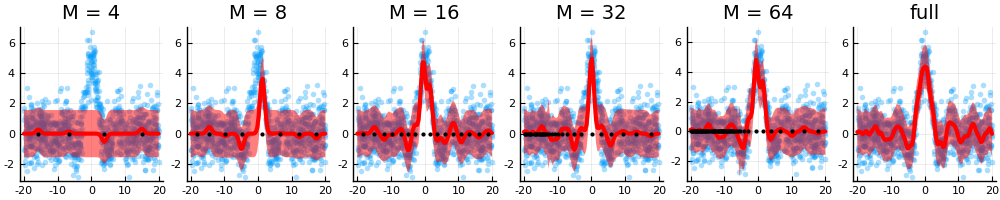

In [38]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))